<a href="https://colab.research.google.com/drive/1tmjp68IcCnLYASeW8Hg5pHyMdeQCIwP-?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prerequisites
Before we start, make sure you have the following:

- Access to a GPU (preferably A100 since videos require high sequence lengths).
- Familiarity with Hugging Face’s Transformers library.
- Pre-install necessary packages by running the below.

In [ ]:
!pip install -U -q transformers accelerate bitsandbytes peft dataset
!pip install -q av
!pip install -q lightning

## Fine-tune VIdeo-LLaVa on MMBench dataset

In this notebook, we are going to fine-tune the [Video-LLaVa](https://huggingface.co/docs/transformers/main/en/model_doc/video_llava) model on [MMBench](https://huggingface.co/datasets/OpenGVLab/MVBench) dataset which is comprised of various video-related tasks. Note that MMBench is quite small and is not made for tuning. Make sure to choose a bigger dataset for your own use-case.

Video-LLaVa is an open-source multimodal model that can accept both, images and videos as input in an interleaved manner. The model architecture is pretty much similar to [LLaVa](https://huggingface.co/docs/transformers/main/en/model_doc/llava). However Video-LLaVa leverages a new universal visial encoder to seemlessly handle both visual modes. As we'll see, fine-tuning these various models is pretty similar as their API is mostly the same.

The goal for the model in this notebook is to answer given multiple choice questions basedd on the video. The questions can be realetd to temporal aspects of the video, pose prediction and so on.
Sources:

* Video-LLaVa [documentation](https://huggingface.co/docs/transformers/main/en/model_doc/video_llava)
* Video-LLaVa [checkpoint on the hub](https://huggingface.co/LanguageBind/Video-LLaVA-7B-hf)

**Note: this notebook is a direct adaptation of Niels' [LLaVa notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LLaVa/Fine_tune_LLaVa_on_a_custom_dataset_(with_PyTorch_Lightning).ipynb).**

## Define variables

We'll first set some variables useful througout this notebook and doo all the necessary imports.

In [ ]:
import os
import av
import re
import bisect
import shutil
import numpy as np
from nltk import edit_distance

from transformers import AutoProcessor
from transformers import BitsAndBytesConfig, VideoLlavaForConditionalGeneration
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from huggingface_hub import snapshot_download
from datasets import load_dataset, concatenate_datasets

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


MAX_LENGTH = 256
MODEL_ID = "LanguageBind/Video-LLaVA-7B-hf"
REPO_ID = "RaushanTurganbay/VideoLLava-demo" # Change to your hf-hub repo

USE_LORA = False
USE_QLORA = True

2024-05-22 18:06:06.577404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 18:06:07.308550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We will start vy downloading and processing the dataset. Even though MMBench is a small dataset, it still requires around 100GB to store the videos, so make sure you have enough free space.

First, we will use this mapping to get the datasets because each one is a separate subset in its own folder. Then we need a few helper functions to download videos and process them to fit the model's format (8 frames each video) .

In [ ]:
config2path = {
    "object_interaction": "star/Charades_v1_480",
    "action_sequence": "star/Charades_v1_480",
    "action_prediction": "star/Charades_v1_480",
    "moving_count": "clevrer/video_validation",
    "moving_attribute": "clevrer/video_validation",
    "object_existence": "clevrer/video_validation",
    "moving_direction": "clevrer/video_validation",
    "counterfactual_inference": "clevrer/video_validation",
    "unexpected_action": "FunQA_test/test",
    "episodic_reasoning": "tvqa/frames_fps3_hq",
    "action_antonym": "ssv2_video",
    "scene_transition": "scene_qa/video",
    "fine_grained_pose": "nturgbd",
    "object_shuffle": "perception/videos",
    "state_change": "perception/videos",
    "character_order": "perception/videos",
    "action_localization": "sta/sta_video",
    "fine_grained_action": "Moments_in_Time_Raw/vi",
    "egocentric_navigation": "vlnqa",
}

In [ ]:
def read_video_pyav(video_path, start, end):
    """Reads a video for given start-end timestamps interval and uniformly samples 8 frames of it"""
    container = av.open(video_path)
    video = container.streams.get(0)[0]

    av_timestamps = [
        int(packet.pts * video.time_base) for packet in container.demux(video) if packet.pts is not None
    ]

    av_timestamps.sort()
    start_id = bisect.bisect_left(av_timestamps, start)
    end_id = bisect.bisect_left(av_timestamps, end)

    # in case it is a very short video, lets take a longer duration and sample
    if end_id  - start_id < 10:
        end_id += 10
        start_id -= 10

    end_id = min(len(av_timestamps) - 1, end_id)
    start_id = max(1, start_id)
    indices = np.linspace(start_id, end_id, 8).astype(int)

    frames = []
    container.seek(0)
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_id:
            break
        if i >= start_id and i in indices:
            frames.append(frame)
    assert len(frames) == 8, f"Got {len(frames)} frames but should be 8. Check the indices: {indices};, start_id: {start_id}, end_id: {end_id}. Len of video is {len(av_timestamps)} frames."
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [ ]:
def collate_read_video(example, path):
    # Some datasets have a start-end interval, so we try to get it if exists. Otherwise just set a very large end timestamp
    clip = read_video_pyav(f'{path}/{example["video"]}', example.get("start", 1), example.get("end", 1e+10))
    example["clip"] = clip
    return example

In [ ]:
# Download the videos from datasets repo and unzip. Make sure you have enough free space before downloading and unzipping
videos = snapshot_download(repo_id="OpenGVLab/MVBench", allow_patterns="*", repo_type="dataset")
for zip_file in os.listdir(f"{videos}/video"):
    if zip_file.endswith(".zip"):
        shutil.unpack_archive(f"{videos}/video/{zip_file}", f"{videos}/videos_unzipped/")

Fetching 40 files:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
# Load each config and save in a mapping
config2ds = {}
for config, path in config2path.items():
    ds = load_dataset("OpenGVLab/MVBench", config, split="train")
    ds = ds.map(collate_read_video, batched=False, fn_kwargs={"path": f"{videos}/videos_unzipped/{path}"})
    config2ds[config] = ds

In [ ]:
processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Custom Dataset Class

In the next step, we'll define a custom dataset class and the necessary functions to prepare our data for fine-tuning the Video-LLaVA model. The VideoLlavaDataset class extends the [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class to facilitate loading and processing "MMBench". This class will handle the conversion of dataset samples into the format required for training and evaluation by preparing a prompt and making array from videos.

NOTE: Video-LLaVa accepts videos in one of the following formats:
- an array or tensor of shape: (batch-size, frames, channel, height, width) where batch-size is an optional dimension
- a list of arrays of shape: (frames, channel, height, width)
- a nested list of video frames, where each frame is an image


Next, we define collate functions to handle the batching of data during training and evaluation. These functions ensure that the input data is properly formatted and padded.

It's only here that we're going to use the processor to turn the (video, target token sequence) into the format that the model expects (which is pixel_values, input_ids etc.). The reason we do that here is because it allows for dynamic padding of the batches: each batch contains ground truth sequences of varying lengths. By only using the processor here, we will pad the input_ids up to the largest sequence in the batch.

We also decide to limit the length of the text tokens (input_ids) to a max length due to memory constraints, feel free to expand if your target token sequences are longer (I'd recommend plotting the average token length of your dataset to determine the optimal value).

The formatting of the input_ids is super important: we need to respect a so-called [chat template](https://huggingface.co/docs/transformers/main/en/chat_templating). As of now, Video-LLaVa does not yet support chat templates, so we manually write down the prompt in the correct format (which starts with USER and ends with ASSISTANT).You could also omit this and just train the model on (video, instruction) pairs without text prompt.

Labels are created for the model by simply copying the inputs to the LLM (input_ids), but with padding tokens replaced by the ignore index of the loss function. This ensures that the model doesn't need to learn to predict padding tokens (used to batch examples together).

Why are the labels a copy of the model inputs, you may ask? The model will internally shift the labels one position to the right so that the model will learn to predict the next token. This can be seen here.

The collate function for evaluation is different, since there we only need to feed the prompt to the model, as we'll use the `generate()` method to autoregressively generate a completion.

In [ ]:
class VideoLlavaDataset(Dataset):
    """
    PyTorch Dataset for VideoLlavaDataset. This class takes a HuggingFace Dataset as input.
    """

    def __init__(
        self,
        dataset: str,
    ):
        super().__init__()
        self.dataset = dataset
        self.id2choice = {0: "A", 1: "B", 2: "C", 3: "D"}

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int):
        sample = self.dataset[idx]
        # cast to np because ds.map() casted everything to list, and the processor does not work list format
        clip = np.array(sample["clip"])

        question, candidates = sample["question"], sample["candidates"]
        answer = candidates.index(sample["answer"])
        answer = self.id2choice[answer]

        mult_choice = ""
        for i, choice in enumerate(candidates):
            mult_choice += f"{self.id2choice[i]}. {choice}; "

        # Prepare a prompt template, can be changed depeding on the dataset and use-cases
        prompt = f"USER: <video>\nAnswer the following multiple choice question based on the video. " \
                f"Question: {question}\n {mult_choice}\n ASSISTANT: Answer: {answer}"

        return prompt, clip

In [ ]:
def train_collate_fn(examples):
    videos = []
    texts = []
    texts, videos = list(zip(*examples))

    batch = processor(text=texts, videos=videos, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"] = labels

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values_videos = batch["pixel_values_videos"]
    labels = batch["labels"]

    return input_ids, attention_mask, pixel_values_videos, labels


def eval_collate_fn(examples):
    # We only feed the prompt to the model
    videos = []
    texts = []
    texts, videos = list(zip(*examples))
    texts = [text[:-2] for text in texts]

    batch = processor(text=texts, videos=videos, padding=True, truncation=True, max_length=MAX_LENGTH, return_tensors="pt")

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    pixel_values_videos = batch["pixel_values_videos"]
    answer_choice = [texts[-1] for text in texts]

    return input_ids, attention_mask, pixel_values_videos, answer_choice

## Combining and Splitting the Dataset
We'll combine multiple datasets, shuffle them, and then split them into training and test sets. This ensures that our model is trained on a diverse and representative sample of the data.

As oftentimes, we get a DatasetDict which is a dictionary containing 3 splits, one for training, validation and testing. Each split has 2 features, an image and a corresponding ground truth.

Let's check the some training example:

In [ ]:
datasets_combined = concatenate_datasets(list(config2ds.values()))
datasets_combined = datasets_combined.shuffle(seed=42)
dataset = datasets_combined.train_test_split(test_size=0.2)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['video', 'question', 'end', 'candidates', 'accurate_end', 'accurate_start', 'start', 'answer', 'clip'],
        num_rows: 1280
    })
    test: Dataset({
        features: ['video', 'question', 'end', 'candidates', 'accurate_end', 'accurate_start', 'start', 'answer', 'clip'],
        num_rows: 320
    })
})

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML


example = dataset['train'][0]
clip = example["clip"]

In [ ]:
# np array with shape (frames, height, width, channels)
video = np.array(clip)

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

In [ ]:
example["question"], example["candidates"], example["answer"]

('Which object was eaten by the person?',
 ['The refrigerator.', 'The medicine.', 'The picture.', 'The sandwich.'],
 'The medicine.')

And now we wrap it in the Pytorch Datasets class and print one example as sanity check.

In [ ]:
train_dataset = VideoLlavaDataset(dataset["train"])
eval_dataset = VideoLlavaDataset(dataset["test"])

In [ ]:
prompt, clip = train_dataset[0]

In [ ]:
prompt

'USER: <video>\nAnswer the following multiple choice question based on the video. Question: Which object was eaten by the person?\n A. The refrigerator.; B. The medicine.; C. The picture.; D. The sandwich.; \n ASSISTANT: Answer: B'

## Load model
Next, we're going to load the Video-LLaVa model from the hub. This is a model with about 7 billion trainable parameters (as it combines a LLaMa-7B language model with a relatively low-parameter vision encoder). Do note that we load a model here which already has undergone supervised fine-tuning (SFT) on VideoChat instruction dataset. We can benefit from the fine-tuning that the model already has undergone.

## Full fine-tuning, LoRa and Q-LoRa
As this model has 7 billion trainable parameters, that's going to have quite an impact on the amount of memory used. For reference, fine-tuning a model using the AdamW optimizer (which is often used to optimize neural networks) with mixed precision, you need about 18 times the amount of parameters in GB of GPU RAM. So in this case, we would need 18x7 billion bytes = 126 GB of GPU RAM if we want to update all the parameters of the model!! That's huge right? And for most people infeasible.

Luckily, some clever people came up with the LoRa method (LoRa is short for low-rank adapation). It allows to just freeze the existing weights and only train a couple of adapter layers on top of the base model. Hugging Face offers the separate [PEFT library](https://huggingface.co/docs/peft/main/en/index) for easy use of LoRa, along with other Parameter-Efficient Fine-Tuning methods (that's where the name PEFT comes from).

Moreover, one can not only freeze the existing base model but also quantize it (which means, shrinking down its size). A neural network's parameters are typically saved in either float32 (which means, 32 bits or 4 bytes are used to store each parameter value) or float16 (which means, 16 bits or half a byte - also called half precision). However, with some clever algorithms one can shrink each parameter to just 8 or 4 bits (half a byte!), without significant effect on final performance. Read all about it here: https://huggingface.co/blog/4bit-transformers-bitsandbytes.

This means that we're going to shrink the size of the base Idefics2-8b model considerably using 4-bit quantization, and then only train a couple of adapter layers on top using LoRa (in float16). This idea of combining LoRa with quantization is called Q-LoRa and is the most memory friendly version.

Of course, if you have the memory available, feel free to use full fine-tuning or LoRa without quantization! In case of full fine-tuning, the code snippet below instantiates the model with Flash Attention which considerably speeds up computations.

There exist many forms of quantization, here we leverage the [BitsAndBytes integration](https://huggingface.co/docs/transformers/main_classes/quantization#transformers.BitsAndBytesConfig).

In [ ]:
## Load model
# Three options for training, from the lowest precision training to the highest precision training:
# QLoRA: model uses 4-bit quantization, which helps in reducing memory usage while maintaining performance.
# Standard LoRA:  model is loaded with standard LoRA adaptations.
# Full Fine-Tuning: no memory optimization are done. In that case Flash Attention is used to speed up training, if hardware supports it.

if USE_QLORA or USE_LORA:
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
        )
    model = VideoLlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
        device_map="auto",
    )
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    # only available on certain devices, see https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file#installation-and-features
    model = VideoLlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
        device_map="auto",
    )

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Apply PEFT
After loading the base model, we're going to add LoRa adapter layers. We're going to only train these adapter layers (the base model is kept frozen).

The difference here with other models are the layers at which we're going to add adapters (in PEFT this is called target_modules). This typically depends a bit on the model.

We defined a function to find all linear layers in the model, excluding any layers related to multimodal projections and vision models. This function will help us identify which layers should have LoRA applied. We're going to add adapters to all linear layers of the model (nn.Linear), except for the ones present in the vision encoder and multimodal projector. This means that we're mostly going to adapt the language model part of Video-LLaVa for our use case.

In [ ]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    multimodal_keywords = ['multi_modal_projector', 'vision_model']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model),
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [ ]:
model

PeftModel(
  (base_model): LoraModel(
    (model): VideoLlavaForConditionalGeneration(
      (video_tower): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(257, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
            (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1024, out_feat

## Define PyTorch Lightning Module for Video-LLaVA
To streamline the training and evaluation of the Video-LLaVA model, we use [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), which abstracts away much of the boilerplate code and provides a structured framework for model training. In this section, we define the VideoLlavaModelPLModule, a custom PyTorch Lightning module that encapsulates the model, training loop, validation loop, and optimizer configuration.

### VideoLlavaModelPLModule Class

The VideoLlavaModelPLModule class inherits from LightningModule and includes methods for training, validation, and optimizer configuration. This setup ensures a clean and efficient training process.

Basically, PyTorch Lightning will take care of all device placements (.to(device)) for us, as well as the backward pass, putting the model in training mode, etc.

Notice the difference between a training step and an evaluation step:

- a training step only consists of a forward pass, in which we compute the cross-entropy loss between the model's next token predictions and the ground truth (in parallel for all tokens, this technique is known as "teacher forcing"). The backward pass is handled by PyTorch Lightning.
- an evaluation step consists of making the model autoregressively complete the prompt using the generate() method. After that, we compute an evaluation metric between the predicted sequences and the ground truth ones. This allows us to see how the model is improving over the course of training. The metric we use here is accuracy of answering the question.

Besides that, we define the optimizer to use (AdamW is a good default choice) and the data loaders, which use the collate functions defined above to batch together items of the PyTorch datasets. Do note that AdamW is a pretty heavy optimizer in terms of memory requirements, but as we're training with QLoRa we only need to store optimizer states for the adapter layers. For full fine-tuning, one could take a look at more memory friendly optimizers such as 8-bit Adam.

In [ ]:
class VideoLlavaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, attention_mask, pixel_values_videos, labels = batch

        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values_videos=pixel_values_videos,
            labels=labels
        )
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values_videos, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values_videos=pixel_values_videos,
            max_new_tokens=MAX_LENGTH,
            do_sample=False,
        )
        # turn them back into text, chopping of the prompt
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        correct = 0
        for pred, answer in zip(predictions, answers):
            correct += (pred.strip().lower() == answer.lower())
        self.log("val_accuracy", correct / len(answers))

        return correct

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(eval_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

Let's instantiate it (based on a config dictionary which defines all hyperparameters for training).

The batch size was determined based on the compute available.

Do note that one can play around with the hyperparameters, I just use good defaults here: 10 epochs, a learning rate of 1e-4 which I found in the original Idefics2 notebook (linked at the top of this notebook), use mixed precision for training (more memory friendly). One could extend this with things like gradient accumulation and gradient checkpointing.

I recommend [this guide](https://huggingface.co/docs/transformers/v4.20.1/en/perf_train_gpu_one) which goes over all tips and tricks regarding maximizing fine-tuning performance on consumer hardware.

In [ ]:
config = {"max_epochs": 2,
          # "val_check_interval": 0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 8,
          "lr": 1e-4,
          "batch_size": 1,
          "num_nodes": 1,
          "warmup_steps": 50,
}

model_module = VideoLlavaModelPLModule(config, processor, model)
early_stop_callback = EarlyStopping(monitor="val_accuracy", patience=3, verbose=False, mode="min")

## Define callbacks
Optionally, Lightning allows to define so-called [callbacks](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html), which are arbitrary pieces of code that can be executed during training.

Here I'm adding a PushToHubCallback which will push the model to the hub at the end of every epoch as well as at the end of training. Do note that you could of course also pass the private=True flag when pushing to the hub, if you wish to keep your model private. Hugging Face also offers the Enterprise Hub so that you can easily share models with your colleagues privately in a secure way.

We'll also use the EarlyStopping callback of Lightning, which will automatically stop training once the evaluation metric (edit distance in our case) doesn't improve after 3 epochs.

In [ ]:
from huggingface_hub import HfApi

api = HfApi()

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Training in progress, epoch {trainer.current_epoch}")

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub(REPO_ID,
                                    commit_message=f"Training done")
        pl_module.model.push_to_hub(REPO_ID,
                                    commit_message=f"Training done")

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

## Train!
Alright, we're set to start training!

Do note that this Trainer class supports many more flags! See the [docs](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.trainer.trainer.Trainer.html#lightning.pytorch.trainer.trainer.Trainer)

In [ ]:
trainer = L.Trainer(
        default_root_dir="/raid/.cache/huggingface/video_llava_demo",
        accelerator="gpu",
        devices=[0],
        max_epochs=config.get("max_epochs"),
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=5,
        num_sanity_val_steps=1,
        callbacks=[early_stop_callback, PushToHubCallback()],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_module)

You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /raid/.cache/huggingface/video_llava_demo/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type      | Params
------------------------------------
0 | model | PeftModel | 3.8 B 
------------------------------------
22.3 M    Trainable params
3.8 B     Non-trainable params
3.8 B     Total params
15,352.594Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)
/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)
/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Tr

Training: |                                                                                                   …

/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)
/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)
/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Tr

Validation: |                                                                                                 …

/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)
/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)
/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Tr

Validation: |                                                                                                 …

/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)
/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)
/home/raushan/transformers/src/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Tr

## Inference

Let's see if the model has learned something. We'll load the model from the hub first. Notice that, as we only trained adapters on top of the base model, the repository on the hub to which we pushed only contains the weights and configuration of the adapters. This is a very lightweight file smaller than 100 MB.

Thanks to the PEFT integration in Transformers, the `from_pretrained` method will automatically load the weights of the base model as well as the adapter weights.

To reduce inference costs, we'll again load the model in 4 bits by passing a `quantization_config`, in order to reduce memory usage.

In [ ]:
from transformers import AutoProcessor, BitsAndBytesConfig, VideoLlavaForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained(MODEL_ID)

# Define quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load the base model with adapters on top
model = VideoLlavaForConditionalGeneration.from_pretrained(
    REPO_ID,
    torch_dtype=torch.float16,
    quantization_config=quantization_config,
    device_map="auto",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/89.5M [00:00<?, ?B/s]

Now we're ready to perform inference. We'll take a one example from the validation set here and plot 8 frames to see what is happening in the video.

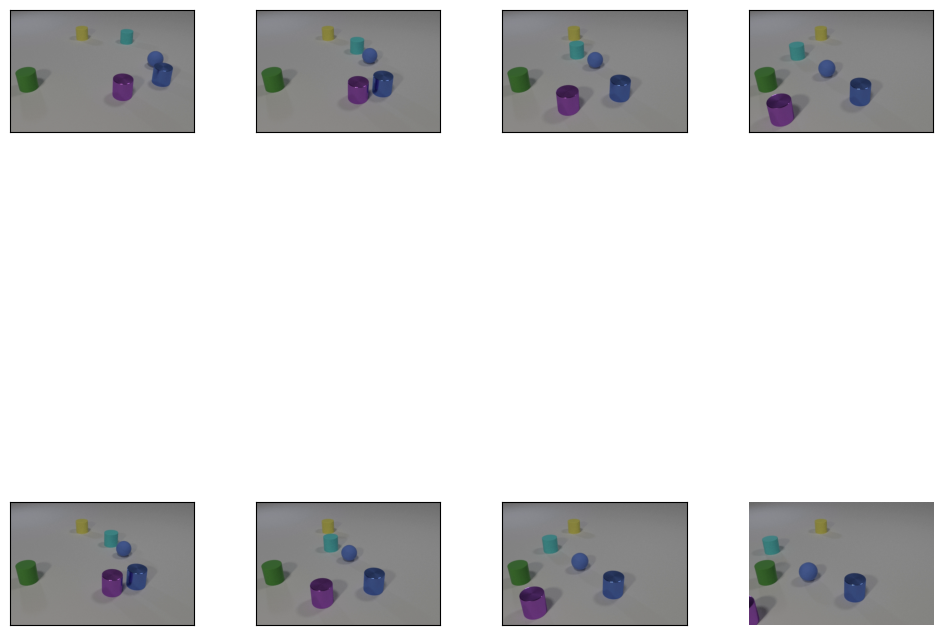

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

prompt, clip = eval_dataset[1]
fig, axarr = plt.subplots(2, 4, figsize = (10, 10))
fig.tight_layout()

for i in range(2):
    for j in range(4):
        curr_frame = Image.fromarray(np.uint8(clip[i + j]))
        axarr[i, j].imshow(curr_frame)
        axarr[i, j].get_xaxis().set_visible(False)
        axarr[i, j].get_yaxis().set_visible(False)
        axarr[i, j].set_aspect('equal')

plt.subplots_adjust(wspace=None, hspace=None)
plt.axis('off')
plt.show()

Next we need to prepare the video for the model, along with the text prompt we used during training. We need to apply the chat template to make sure the format is respected.

Notice that this is exactly the same as what we did for the evaluation data collate function.

In [ ]:
answer = prompt[-1]
prompt = prompt[:-2]

inputs = processor(text=prompt, videos=clip, return_tensors="pt").to(model.device)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values_videos torch.Size([1, 8, 3, 224, 224])
input_ids torch.Size([1, 94])
attention_mask torch.Size([1, 94])


Next we let the model autoregressively generate tokens using the [generate()](https://huggingface.co/docs/transformers/v4.40.1/en/main_classes/text_generation#transformers.GenerationMixin.generate) method, which is recommended for use at inference time. This method feeds each predicted token back into the model as conditioning for each next time step.

Do note that there are various ways of decoding text, here we use greedy decoding which is the default. There are various fancier methods such as beam search and top-k sampling. Refer to [this amazing blog post](https://huggingface.co/blog/how-to-generate) for all details.

In [ ]:
# Generate token IDs
generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)

# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

In [ ]:
print(generated_texts)

['USER:  \nAnswer the following multiple choice question based on the video. Question: What will happen if the sphere is removed?\n A. The blue cylinder collides with the cyan cylinder; B. The blue cylinder collides with the yellow cylinder; C. The green object collides with the yellow object; D. The blue cylinder collides with the green object; \n ASSISTANT: Answer: A']


In [ ]:
print(answer)

A
